In [ ]:
#Importing packages for necessary purposes

import numpy as np
from tensorflow import keras
import pandas as pd
import tensorflow as tf
import re
import nltk

from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

import matplotlib.pyplot as plt

In [ ]:
#Importing data
imdb_data = pd.read_csv('data/IMDB Dataset.csv')
imdb_data.isnull().values.any()
print (imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
#cleaning reviews
def review_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(imdb_data['review'])
for sen in sentences:
    X.append(review_text(sen))

In [ ]:
#converting positive to 1 and negative to 0
Y = imdb_data['sentiment']

Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [ ]:
seed=42
np.random.seed(seed)

In [ ]:
#shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X_temp, Y_train = np.array(X)[idx], Y[idx]
X_train = []
for sen in X_temp:
    X_train.append(sen)

In [ ]:
#splitting the data into 70:30 train:test
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(len(X_train))
print(len(X_test))

35000
15000


In [ ]:
#Tokenization of text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

#cutoff word length per review
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

87633

In [ ]:
#dictionary
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(87633, 100)

In [ ]:
#Model definition
max_fatures = vocab_size
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = embedding_matrix.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          11217024  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 11,472,218
Trainable params: 11,472,218
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
histories = {}

In [ ]:
X_train.shape

(35000, 100)

In [ ]:
histories['base'] = model.fit(X_train, Y_train, epochs = 50, batch_size=32, verbose = 2, validation_data=(X_test,Y_test), shuffle=True)

Epoch 1/50
1094/1094 - 494s - loss: 0.4485 - accuracy: 0.7863 - val_loss: 0.3991 - val_accuracy: 0.8266
Epoch 2/50
1094/1094 - 493s - loss: 0.3160 - accuracy: 0.8694 - val_loss: 0.3238 - val_accuracy: 0.8653
Epoch 3/50
1094/1094 - 493s - loss: 0.2724 - accuracy: 0.8904 - val_loss: 0.3296 - val_accuracy: 0.8605
Epoch 4/50
1094/1094 - 498s - loss: 0.2351 - accuracy: 0.9075 - val_loss: 0.3285 - val_accuracy: 0.8581
Epoch 5/50
1094/1094 - 498s - loss: 0.2078 - accuracy: 0.9183 - val_loss: 0.3427 - val_accuracy: 0.8601
Epoch 6/50
1094/1094 - 498s - loss: 0.1867 - accuracy: 0.9265 - val_loss: 0.3794 - val_accuracy: 0.8627
Epoch 7/50
1094/1094 - 496s - loss: 0.1670 - accuracy: 0.9354 - val_loss: 0.4294 - val_accuracy: 0.8611
Epoch 8/50
1094/1094 - 496s - loss: 0.1482 - accuracy: 0.9438 - val_loss: 0.4142 - val_accuracy: 0.8577
Epoch 9/50
1094/1094 - 496s - loss: 0.1347 - accuracy: 0.9499 - val_loss: 0.4641 - val_accuracy: 0.8561
Epoch 10/50
1094/1094 - 495s - loss: 0.1243 - accuracy: 0.9529 -

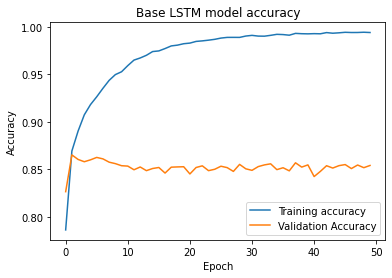

In [ ]:
# plot learning curves
plt.plot(histories['base'].history['accuracy'])
plt.plot(histories['base'].history['val_accuracy'])
plt.title('Base LSTM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

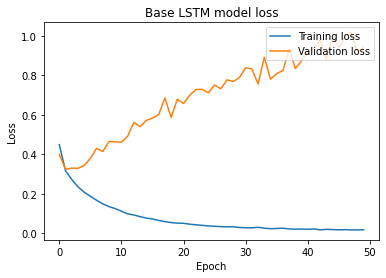

In [ ]:
# plot learning curves
plt.plot(histories['base'].history['loss'])
plt.plot(histories['base'].history['val_loss'])
plt.title('Base LSTM model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()